In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 날씨 데이터 불러오기

In [2]:
# whether csv read, 일시를 index로 넣고 datetime 형태로 변환함
whether = pd.read_csv('./data/Whether.csv', encoding='euc-kr', parse_dates=['일시'], index_col='일시')
# 강수량, 적설이 null인 경우 모두 0으로 바꿈
whether = whether.fillna(0)
# 일시의 freq을 hour로 변경
whether.index.freq = 'h'

# 지점코드, 지점명을 없앰
whether = whether.iloc[:, [2,3,4,5,6]]
whether

,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm)
일시,,,,,
2020-10-01 00:00:00,17.3,0.0,0.2,92.0,0.0
2020-10-01 01:00:00,16.8,0.0,0.5,94.0,0.0
2020-10-01 02:00:00,16.9,0.0,1.1,93.0,0.0
2020-10-01 03:00:00,16.8,0.0,0.4,94.0,0.0
2020-10-01 04:00:00,16.1,0.0,0.1,95.0,0.0
...,...,...,...,...,...
2022-10-01 19:00:00,21.1,0.0,0.1,54.0,0.0
2022-10-01 20:00:00,19.6,0.0,0.6,63.0,0.0
2022-10-01 21:00:00,18.8,0.0,0.7,73.0,0.0


# 차량 데이터 불러오기 및 전처리

장비별, 일시별 구분  
입차 대수 - 출차 대수 = 현재 차량 대수  
한맥의 경우 FilePath로부터 입출차 시간 추출  
정기권 등 구분 X

In [4]:
def pretreatment(df):
    df['일시'] = pd.to_datetime(df['FilePath'].apply(lambda x: x[12:26]), format='%Y%m%d%H%M%S')
    df['일시'] = pd.to_datetime(df['일시']).apply(del_min_sec)
    df = df[['일시', 'FilePath', 'InOutDiv']]
    df = df.rename({'FilePath':'주차일련번호'}, axis=1)
    return df

def del_min_sec(x):
    return x.replace(minute=0, second=0)

car_normal = pd.read_csv('./data/일반차량.csv')
car_normal = pretreatment(car_normal)

car_ticket = pd.read_csv('./data/정기권차량.csv')
car_ticket = pretreatment(car_ticket)

hanmeak = pd.concat([car_normal, car_ticket]).sort_values('일시')

hanmeak_in = hanmeak[hanmeak['InOutDiv']==1].iloc[:,:2]
hanmeak_in = hanmeak_in.groupby('일시').count().reset_index().rename({'주차일련번호':'입차대수'}, axis=1)

hanmeak_out = hanmeak[hanmeak['InOutDiv']==2].iloc[:,:2]
hanmeak_out = hanmeak_out.groupby('일시').count().reset_index().rename({'주차일련번호':'출차대수'}, axis=1)

hanmeak_all = pd.merge(hanmeak_in, hanmeak_out, on='일시', how='outer').fillna(0).sort_values('일시').reset_index(drop=True)
hanmeak_all['입출차 차이'] = hanmeak_all['입차대수'] - hanmeak_all['출차대수']
hanmeak_all

,일시,입차대수,출차대수,입출차 차이
0,2020-10-01 04:00:00,1.0,0.0,1.0
1,2020-10-01 05:00:00,0.0,1.0,-1.0
2,2020-10-01 08:00:00,4.0,0.0,4.0
3,2020-10-01 09:00:00,2.0,0.0,2.0
4,2020-10-01 10:00:00,0.0,1.0,-1.0
...,...,...,...,...
12312,2022-10-01 19:00:00,4.0,11.0,-7.0
12313,2022-10-01 20:00:00,1.0,6.0,-5.0
12314,2022-10-01 21:00:00,1.0,3.0,-2.0
12315,2022-10-01 22:00:00,2.0,1.0,1.0


# 분석

2022년 9월 1일 ~ 2022년 10월 1일

In [5]:
from datetime import datetime
set_time = pd.date_range('20201001', '20221001230000', freq='h')

## 한맥

In [6]:
hanmeak_analysis = pd.DataFrame(index=set_time)
hanmeak_analysis = pd.merge(hanmeak_analysis, hanmeak_all, left_index=True, right_on='일시', how='left').fillna(0)
hanmeak_analysis = hanmeak_analysis.set_index('일시')
hanmeak_analysis['입출차 누계'] = hanmeak_analysis['입출차 차이'].cumsum()
# 누계가 음수인 경우, 최솟값만큼 기존에 차가 있었다고 가정함
if hanmeak_analysis['입출차 누계'].min() < 0:
    hanmeak_analysis['입출차 누계'] -= hanmeak_analysis['입출차 누계'].min()
hanmeak_analysis = pd.merge(hanmeak_analysis[['입출차 누계']], whether, left_index=True, right_index=True, how='left')
hanmeak_analysis.index.freq='h'
hanmeak_analysis

,입출차 누계,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm)
일시,,,,,,
2020-10-01 00:00:00,5.0,17.3,0.0,0.2,92.0,0.0
2020-10-01 01:00:00,5.0,16.8,0.0,0.5,94.0,0.0
2020-10-01 02:00:00,5.0,16.9,0.0,1.1,93.0,0.0
2020-10-01 03:00:00,5.0,16.8,0.0,0.4,94.0,0.0
2020-10-01 04:00:00,6.0,16.1,0.0,0.1,95.0,0.0
...,...,...,...,...,...,...
2022-10-01 19:00:00,166.0,21.1,0.0,0.1,54.0,0.0
2022-10-01 20:00:00,161.0,19.6,0.0,0.6,63.0,0.0
2022-10-01 21:00:00,159.0,18.8,0.0,0.7,73.0,0.0


### SARIMAX

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

train_hanmeak = hanmeak_analysis[hanmeak_analysis.index < datetime(2022, 10, 1)]
train_x = train_hanmeak.iloc[:, 1:]
train_y = train_hanmeak.iloc[:, 0]

test_hanmeak = hanmeak_analysis[hanmeak_analysis.index >= datetime(2022, 10, 1)]
test_x = test_hanmeak.iloc[:, 1:]
test_y = test_hanmeak.iloc[:, 0]

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

p=d=q=range(2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p,d,q))]
min_aic = np.inf
for param in pdq:
    print(param)
    for param_seasonal in seasonal_pdq:
        try:
            tmp_model = SARIMAX(train_y, exog=train_x, order=param, seasonal_order=param_seasonal, freq='h').fit(disp=False)
            tmp_aic = tmp_model.aic
            tmp_pred = tmp_model.forecast(24, exog=test_x)
            if (abs(tmp_aic) < abs(min_aic)) & (abs(tmp_aic)>100):
                if len(tmp_pred[tmp_pred<0]) <= 0:
                    min_aic = tmp_aic
                    best_model = tmp_model
                    best_param = (param, param_seasonal)
        except np.linalg.LinAlgError:
            continue
prediction = best_model.forecast(24, exog=test_x)

(0, 0, 0)


C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 1)


C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0)
(0, 1, 1)
(1, 0, 0)


C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 1)


C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0)


C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1)


C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kyw65\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
best_param

((1, 1, 1), (1, 1, 1, 24))

In [18]:
MAE = mean_absolute_error(test_y, prediction)
MAE_per = sum(abs(test_y - prediction)) / sum(test_y) * 100
print('MAE =', MAE)
print('MAE_per =', MAE_per)
RMSE = np.sqrt(mean_squared_error(test_y, prediction))
RMSE_per = (np.sqrt(np.mean(np.square((test_y - prediction) / test_y)))) * 100
print('RMSE =', RMSE)
print('RMSE(per) =', RMSE_per)

MAE = 4.909601478031173
MAE_per = 2.9420832827153096
RMSE = 6.2120331373594935
RMSE(per) = 3.712057443280466


<AxesSubplot:>

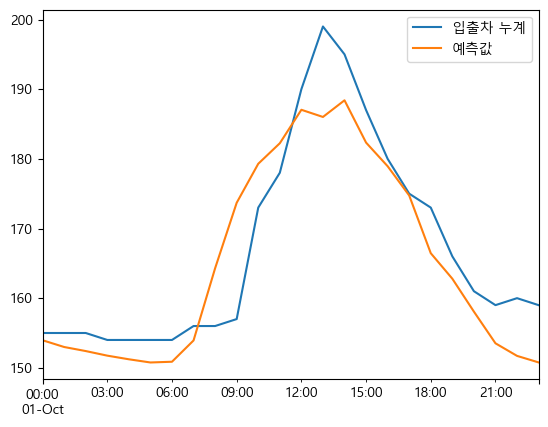

In [22]:
prediction.name = '예측값'
pd.concat([test_y, prediction], axis=1).plot()